In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random 
import time
import cv2

from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split



In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:

PROJECT_ROOT = Path().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"

csv_path = PROCESSED_DIR / "person_clean_dataset.csv"

df = pd.read_csv(csv_path)
print("Rows in dataset:", len(df))
df.head()

Rows in dataset: 1768


image_id                                         image_path  \
0  00d449b98c6c9d53  ../data/raw_images/train/person/00d449b98c6c9d...   
1  00dcfd103c9f5ca2  ../data/raw_images/train/person/00dcfd103c9f5c...   
2  00e71dd7bd07a35d  ../data/raw_images/train/person/00e71dd7bd07a3...   
3  003e8ba2ccad2bc6  ../data/raw_images/train/person/003e8ba2ccad2b...   
4  03c921fb5a7fd2b0  ../data/raw_images/train/person/03c921fb5a7fd2...   

       XMin      XMax      YMin      YMax  
0  0.166667  0.846667  0.208750  0.808750  
1  0.015000  0.196250  0.150943  0.798113  
2  0.000000  0.658594  0.000000  0.998824  
3  0.360938  0.946875  0.069792  0.854167  
4  0.299219  0.418750  0.512695  0.889648

In [4]:
# compute center (xc, yc) and width/height (w, h) in normalized [0,1]
df["xc"] = (df["XMin"] + df["XMax"]) / 2.0
df["yc"] = (df["YMin"] + df["YMax"]) / 2.0
df["w"]  = df["XMax"] - df["XMin"]
df["h"]  = df["YMax"] - df["YMin"]

df[["image_path", "xc", "yc", "w", "h"]].head()


image_path        xc        yc  \
0  ../data/raw_images/train/person/00d449b98c6c9d...  0.506667  0.508750   
1  ../data/raw_images/train/person/00dcfd103c9f5c...  0.105625  0.474528   
2  ../data/raw_images/train/person/00e71dd7bd07a3...  0.329297  0.499412   
3  ../data/raw_images/train/person/003e8ba2ccad2b...  0.653906  0.461979   
4  ../data/raw_images/train/person/03c921fb5a7fd2...  0.358985  0.701172   

          w         h  
0  0.680000  0.600000  
1  0.181250  0.647170  
2  0.658594  0.998824  
3  0.585937  0.784375  
4  0.119531  0.376953

In [5]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

len(train_df), len(val_df)

(1414, 354)

In [6]:
class CropDataset(Dataset):
    def __init__(self, df, transform=None, image_size=224, max_retries=10):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_size = image_size
        self.max_retries = max_retries

        # basic transform if none provided
        if self.transform is None:
            self.transform = T.Compose([
                T.Resize((image_size, image_size)),
                T.ToTensor(),
                # normalize with ImageNet stats (good default)
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Retry sampling if file is missing/corrupt
        for _ in range(self.max_retries):
            row = self.df.iloc[idx]
            img_path = row["image_path"]

            # If file missing, resample another index
            if not os.path.exists(img_path):
                idx = random.randint(0, len(self.df) - 1)
                continue

            try:
                img = Image.open(img_path).convert("RGB")
            except Exception:
                # Corrupt/unreadable file: resample
                idx = random.randint(0, len(self.df) - 1)
                continue

            # normalized target box (already [0,1])
            target = np.array([row["xc"], row["yc"], row["w"], row["h"]], dtype=np.float32)

            img = self.transform(img)
            target = torch.tensor(target, dtype=torch.float32)

            return img, target

        # If too many failures, raise a clear error
        raise RuntimeError(
            f"CropDataset: exceeded max_retries={self.max_retries} for missing/corrupt images. "
            "Consider filtering df['image_path'] to existing files."
        )

In [7]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

train_dataset = CropDataset(train_df, image_size=IMAGE_SIZE)
val_dataset   = CropDataset(val_df, image_size=IMAGE_SIZE)

g = torch.Generator()
g.manual_seed(SEED)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, generator=g)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

len(train_loader), len(val_loader)

(89, 23)

In [8]:
class CropRegressor(nn.Module):
    def __init__(self, embed_dim=1280, hidden_dim=128, min_wh=0.05):
        super().__init__()
        self.min_wh = float(min_wh)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, 4),
            nn.Sigmoid(),
        )

    def forward(self, feats):
        out = self.mlp(feats)  # (B,4) in (0,1)

        xc = out[:, 0]
        yc = out[:, 1]
        w  = out[:, 2].clamp(min=self.min_wh)
        h  = out[:, 3].clamp(min=self.min_wh)

        half_w = 0.5 * w
        half_h = 0.5 * h

        xc = xc.clamp(min=half_w, max=1.0 - half_w)
        yc = yc.clamp(min=half_h, max=1.0 - half_h)

        # rebuild tensor (NOT in-place)
        return torch.stack([xc, yc, w, h], dim=1)



We used pretrained EfficientNet-B0. It is designed to be incredibly efficient but usually achieves much higher accuracy than MobileNet or ResNet by carefully balancing depth, width, and resolution.

In [9]:
class PretrainedCropModel(nn.Module):
    def __init__(self): # 576 is for mobilenet_v3_small
        super().__init__()
        # 1. Load Pretrained Backbone
        # backbone = models.mobilenet_v3_small(weights='DEFAULT')
        backbone = models.efficientnet_b0(weights='DEFAULT')
        self.backbone = backbone.features
        
        # 2. Remove the classification head (classifier) to get features
        # MobileNet stores features in .features, followed by pooling
        self.backbone = backbone.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # 3. Attach your custom regression head
        # Note: We reuse your CropRegressor from Cell 9
        self.head = CropRegressor(embed_dim=1280)

    def forward(self, x):
        x = self.backbone(x)      # Extract features
        x = self.pool(x)          # Global Average Pool
        x = x.flatten(1)          # Flatten to (B, embed_dim)
        pred_boxes = self.head(x) # Regress box
        return pred_boxes

In [10]:
def box_xywh_to_xyxy(box, eps=1e-6):
    """
    box: (B,4) in (xc,yc,w,h), assumed normalized (0..1)
    returns (B,4) in (x1,y1,x2,y2), clipped to (0..1)
    """
    xc, yc, w, h = box[:, 0], box[:, 1], box[:, 2], box[:, 3]
    w = w.clamp(min=eps)
    h = h.clamp(min=eps)

    x1 = (xc - 0.5 * w)
    y1 = (yc - 0.5 * h)
    x2 = (xc + 0.5 * w)
    y2 = (yc + 0.5 * h)

    xyxy = torch.stack([x1, y1, x2, y2], dim=1)
    return xyxy.clamp(0.0, 1.0)

def iou_loss(pred, target, eps=1e-6, giou=False, reduction="mean"):
    """
    pred, target: (B,4) in [0,1] as (xc,yc,w,h)
    Returns: 1 - IoU (or 1 - GIoU)
    """
    pred_xyxy = box_xywh_to_xyxy(pred, eps=eps)
    tgt_xyxy  = box_xywh_to_xyxy(target, eps=eps)

    # Intersection
    x1 = torch.max(pred_xyxy[:, 0], tgt_xyxy[:, 0])
    y1 = torch.max(pred_xyxy[:, 1], tgt_xyxy[:, 1])
    x2 = torch.min(pred_xyxy[:, 2], tgt_xyxy[:, 2])
    y2 = torch.min(pred_xyxy[:, 3], tgt_xyxy[:, 3])

    inter_w = (x2 - x1).clamp(min=0)
    inter_h = (y2 - y1).clamp(min=0)
    inter = inter_w * inter_h

    # Areas
    area_pred = (pred_xyxy[:, 2] - pred_xyxy[:, 0]).clamp(min=0) * \
                (pred_xyxy[:, 3] - pred_xyxy[:, 1]).clamp(min=0)
    area_tgt  = (tgt_xyxy[:, 2] - tgt_xyxy[:, 0]).clamp(min=0) * \
                (tgt_xyxy[:, 3] - tgt_xyxy[:, 1]).clamp(min=0)

    union = area_pred + area_tgt - inter + eps
    iou = inter / union  # (B,)

    if giou:
        # Enclosing box
        cx1 = torch.min(pred_xyxy[:, 0], tgt_xyxy[:, 0])
        cy1 = torch.min(pred_xyxy[:, 1], tgt_xyxy[:, 1])
        cx2 = torch.max(pred_xyxy[:, 2], tgt_xyxy[:, 2])
        cy2 = torch.max(pred_xyxy[:, 3], tgt_xyxy[:, 3])

        c_area = (cx2 - cx1).clamp(min=0) * (cy2 - cy1).clamp(min=0) + eps
        giou_val = iou - (c_area - union) / c_area
        loss_vec = 1.0 - giou_val
    else:
        loss_vec = 1.0 - iou

    if reduction == "mean":
        return loss_vec.mean()
    if reduction == "sum":
        return loss_vec.sum()
    return loss_vec

def compute_metrics(pred, target, eps=1e-6):
    """
    Computes diagnostic metrics for validation.
    Returns:
        iou: Intersection over Union (0 to 1)
        containment: What % of the GT is inside the Prediction (0 to 1)
    """
    # 1. Convert to x1, y1, x2, y2
    pred_xyxy = box_xywh_to_xyxy(pred, eps=eps)
    tgt_xyxy  = box_xywh_to_xyxy(target, eps=eps)

    # 2. Intersection
    x1 = torch.max(pred_xyxy[:, 0], tgt_xyxy[:, 0])
    y1 = torch.max(pred_xyxy[:, 1], tgt_xyxy[:, 1])
    x2 = torch.min(pred_xyxy[:, 2], tgt_xyxy[:, 2])
    y2 = torch.min(pred_xyxy[:, 3], tgt_xyxy[:, 3])

    inter_w = (x2 - x1).clamp(min=0)
    inter_h = (y2 - y1).clamp(min=0)
    inter = inter_w * inter_h

    # 3. Areas
    area_pred = (pred_xyxy[:, 2] - pred_xyxy[:, 0]).clamp(min=0) * \
                (pred_xyxy[:, 3] - pred_xyxy[:, 1]).clamp(min=0)
    area_tgt  = (tgt_xyxy[:, 2] - tgt_xyxy[:, 0]).clamp(min=0) * \
                (tgt_xyxy[:, 3] - tgt_xyxy[:, 1]).clamp(min=0)

    # 4. Compute Metrics
    union = area_pred + area_tgt - inter + eps
    
    iou = inter / union
    containment = inter / (area_tgt + eps) # How much of the Target did we capture?

    return iou.mean(), containment.mean()

smooth_l1 = nn.SmoothL1Loss()


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# model = TinyViTCropModel(img_size=IMAGE_SIZE).to(device)
model = PretrainedCropModel().to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Drop Learning Rate by 10x every 5 epochs to force fine-tuning
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 15  # you can increase later

print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print("Train samples:", len(train_df))
print("Val samples:", len(val_df))

Using device: cpu
Device: cpu
Train samples: 1414
Val samples: 354


In [12]:
# --- HELPER METRICS FUNCTIONS ---
def compute_metrics(pred, target, eps=1e-6):
    """
    Computes diagnostic metrics for validation.
    Returns:
        iou: Intersection over Union (0 to 1) - Higher is better
        containment: What % of the GT is inside the Prediction (0 to 1) - Higher means we captured the subject
    """
    # 1. Convert normalized (xc, yc, w, h) -> (x1, y1, x2, y2)
    pred_xyxy = box_xywh_to_xyxy(pred, eps=eps)
    tgt_xyxy  = box_xywh_to_xyxy(target, eps=eps)

    # 2. Intersection
    x1 = torch.max(pred_xyxy[:, 0], tgt_xyxy[:, 0])
    y1 = torch.max(pred_xyxy[:, 1], tgt_xyxy[:, 1])
    x2 = torch.min(pred_xyxy[:, 2], tgt_xyxy[:, 2])
    y2 = torch.min(pred_xyxy[:, 3], tgt_xyxy[:, 3])

    inter_w = (x2 - x1).clamp(min=0)
    inter_h = (y2 - y1).clamp(min=0)
    inter = inter_w * inter_h

    # 3. Areas
    area_pred = (pred_xyxy[:, 2] - pred_xyxy[:, 0]).clamp(min=0) * \
                (pred_xyxy[:, 3] - pred_xyxy[:, 1]).clamp(min=0)
    area_tgt  = (tgt_xyxy[:, 2] - tgt_xyxy[:, 0]).clamp(min=0) * \
                (tgt_xyxy[:, 3] - tgt_xyxy[:, 1]).clamp(min=0)

    # 4. Compute Metrics
    union = area_pred + area_tgt - inter + eps
    
    iou = inter / union
    containment = inter / (area_tgt + eps) 

    return iou.mean(), containment.mean()


# --- TRAINING FUNCTIONS ---

def train_one_epoch(model, loader, optimizer, device, epoch=None):
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for batch_idx, (imgs, targets) in enumerate(loader, start=1):
        imgs = imgs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        preds = model(imgs)

        # Loss Calculation
        l1 = smooth_l1(preds, targets)
        iou = iou_loss(preds, targets, giou=True) # Recommended: Use GIoU for better gradients
        loss = l1 + iou

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    epoch_loss = total_loss / len(loader.dataset)
    epoch_time = time.time() - start_time
    
    # Print simpler progress
    print(f"→ Epoch {epoch} [Train] Loss: {epoch_loss:.4f} | Time: {epoch_time:.2f}s")
    return epoch_loss, epoch_time


@torch.no_grad()
def eval_one_epoch(model, loader, device, epoch=None):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_cont = 0.0
    
    # We count batches to average metrics later
    num_batches = len(loader) 

    for batch_idx, (imgs, targets) in enumerate(loader, start=1):
        imgs = imgs.to(device)
        targets = targets.to(device)

        preds = model(imgs)
        
        # Loss
        l1 = smooth_l1(preds, targets)
        iou_l = iou_loss(preds, targets, giou=True)
        loss = l1 + iou_l

        total_loss += loss.item() * imgs.size(0)
        
        # Metrics
        batch_iou, batch_cont = compute_metrics(preds, targets)
        total_iou += batch_iou.item()
        total_cont += batch_cont.item()

    # Averages
    epoch_loss = total_loss / len(loader.dataset)
    avg_iou = total_iou / num_batches
    avg_cont = total_cont / num_batches

    print(f"→ Epoch {epoch} [Val]   Loss: {epoch_loss:.4f} | IoU: {avg_iou:.4f} | Containment: {avg_cont:.4f}")
    
    # Return all three so we can log them
    return epoch_loss, avg_iou, avg_cont


# --- MAIN LOOP ---
training_log = []

best_val_iou = 0.0
checkpoint_path ="../models/best_aesthetic_cropper.pth"


for epoch in range(1, num_epochs + 1):
    # Train
    train_loss, epoch_time = train_one_epoch(
        model, train_loader, optimizer, device, epoch=epoch
    )

    # Validate (Now returns 3 values)
    val_loss, val_iou, val_cont = eval_one_epoch(
        model, val_loader, device, epoch=epoch
    )

    scheduler.step()
    
    # Log
    training_log.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_iou": val_iou,             # <--- New useful log
        "val_containment": val_cont,    # <--- New useful log
        "epoch_time_sec": epoch_time,
        "learning_rate": optimizer.param_groups[0]["lr"],
    })

    # Check if this is the best model so far
    if val_iou > best_val_iou:
        print(f"Best Model IoU Score: {best_val_iou:.4f} → {val_iou:.4f}")
        best_val_iou = val_iou
        
        # Save the model weights
        torch.save(model.state_dict(), checkpoint_path)

    print("-" * 70)

# Create DataFrame
training_df = pd.DataFrame(training_log)

→ Epoch 1 [Train] Loss: 0.7183 | Time: 192.53s
→ Epoch 1 [Val]   Loss: 0.6984 | IoU: 0.3757 | Containment: 0.7351
Best Model IoU Score: 0.0000 → 0.3757
----------------------------------------------------------------------
→ Epoch 2 [Train] Loss: 0.6373 | Time: 187.04s
→ Epoch 2 [Val]   Loss: 0.6782 | IoU: 0.3918 | Containment: 0.7616
Best Model IoU Score: 0.3757 → 0.3918
----------------------------------------------------------------------
→ Epoch 3 [Train] Loss: 0.6077 | Time: 177.93s
→ Epoch 3 [Val]   Loss: 0.6738 | IoU: 0.3935 | Containment: 0.7492
Best Model IoU Score: 0.3918 → 0.3935
----------------------------------------------------------------------
→ Epoch 4 [Train] Loss: 0.5750 | Time: 177.06s
→ Epoch 4 [Val]   Loss: 0.6586 | IoU: 0.4037 | Containment: 0.7459
Best Model IoU Score: 0.3935 → 0.4037
----------------------------------------------------------------------
→ Epoch 5 [Train] Loss: 0.5484 | Time: 174.70s
→ Epoch 5 [Val]   Loss: 0.6450 | IoU: 0.4202 | Containment: 0

In [13]:
training_df

epoch  train_loss  val_loss   val_iou  val_containment  epoch_time_sec  \
0       1    0.718328  0.698351  0.375706         0.735066      192.530351   
1       2    0.637307  0.678224  0.391766         0.761620      187.037889   
2       3    0.607749  0.673825  0.393461         0.749165      177.928897   
3       4    0.575015  0.658598  0.403681         0.745913      177.058583   
4       5    0.548439  0.645030  0.420176         0.753159      174.697594   
5       6    0.526432  0.642311  0.423525         0.751801      177.147761   
6       7    0.514840  0.642105  0.424191         0.732053      175.910781   
7       8    0.508386  0.639810  0.424094         0.744892      177.842209   
8       9    0.505791  0.646459  0.421764         0.707840      175.364665   
9      10    0.503911  0.636833  0.426245         0.749979      175.476358   
10     11    0.498011  0.640741  0.424637         0.729959      175.952943   
11     12    0.500012  0.641302  0.424747         0.722728      180.287136   
12     13    0.495950  0.640086  0.426392         0.729957      177.033085   
13     14    0.495619  0.641570  0.425903         0.717481      175.160817   
14     15    0.495853  0.638187  0.426522         0.739724      174.759589   

    learning_rate  
0    1.000000e-04  
1    1.000000e-04  
2    1.000000e-04  
3    1.000000e-04  
4    1.000000e-05  
5    1.000000e-05  
6    1.000000e-05  
7    1.000000e-05  
8    1.000000e-05  
9    1.000000e-06  
10   1.000000e-06  
11   1.000000e-06  
12   1.000000e-06  
13   1.000000e-06  
14   1.000000e-07

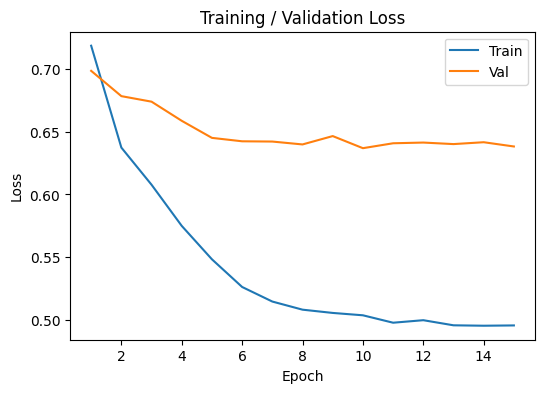

In [14]:
plt.figure(figsize=(6,4))

plt.plot(training_df["epoch"], training_df["train_loss"], label="Train")
plt.plot(training_df["epoch"], training_df["val_loss"], label="Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation Loss")
plt.legend()
plt.show()


The supervised TinyViT crop regression model converged after fine-tuning at a learning rate of 1e-5, with stable and smoothly decreasing training and validation losses. Further training yielded diminishing returns, indicating convergence.

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


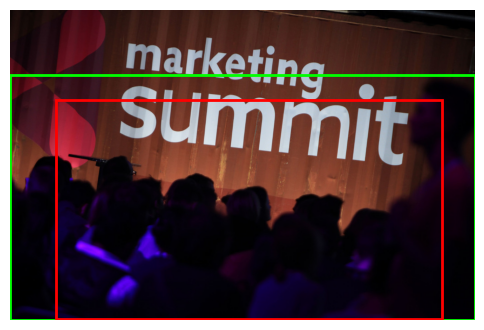

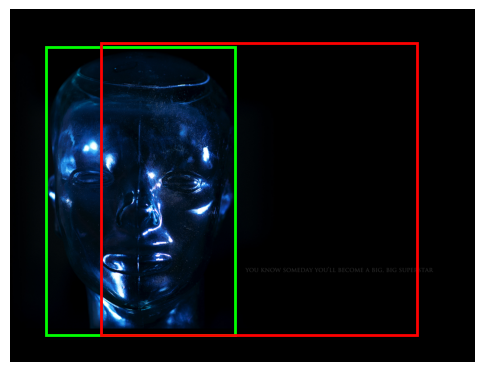

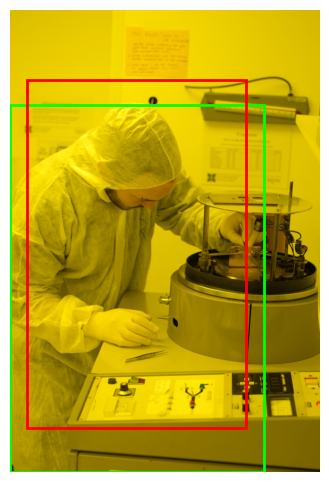

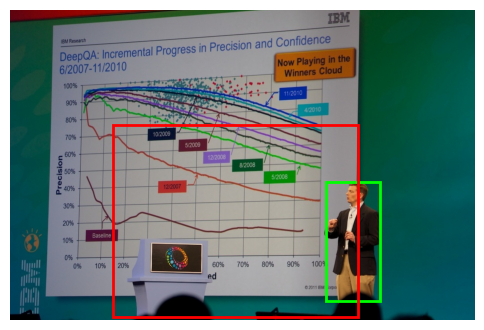

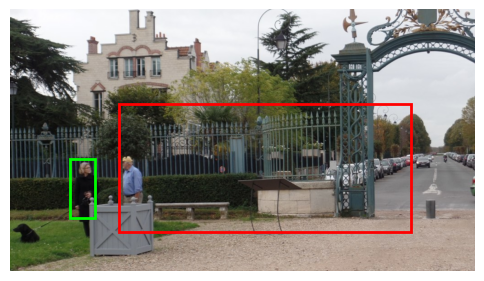

In [15]:
@torch.no_grad()
def visualize_predictions(model, df_sample, num_samples=5):
    model.eval()
    for i in range(num_samples):
        row = df_sample.sample(1).iloc[0]
        img_path = row["image_path"]
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        # prepare input
        x = train_dataset.transform(img).unsqueeze(0).to(device)  # reuse transform
        pred = model(x).cpu().squeeze(0).numpy()

        # gt & pred boxes (xc,yc,w,h)
        gt = np.array([row["xc"], row["yc"], row["w"], row["h"]])

        def xywh_to_xyxy(box):
            xc, yc, bw, bh = box
            x1 = (xc - bw/2) * w
            y1 = (yc - bh/2) * h
            x2 = (xc + bw/2) * w
            y2 = (yc + bh/2) * h
            return x1, y1, x2, y2

        gt_x1, gt_y1, gt_x2, gt_y2 = xywh_to_xyxy(gt)
        pr_x1, pr_y1, pr_x2, pr_y2 = xywh_to_xyxy(pred)

        fig, ax = plt.subplots(1, figsize=(6,6))
        ax.imshow(img)

        # GT in green
        ax.add_patch(
            patches.Rectangle(
                (gt_x1, gt_y1),
                gt_x2 - gt_x1, gt_y2 - gt_y1,
                linewidth=2, edgecolor="lime", facecolor="none", label="GT"
            )
        )
        # Pred in red
        ax.add_patch(
            patches.Rectangle(
                (pr_x1, pr_y1),
                pr_x2 - pr_x1, pr_y2 - pr_y1,
                linewidth=2, edgecolor="red", facecolor="none", label="Pred"
            )
        )

        plt.axis("off")
        plt.show()


visualize_predictions(model, val_df, num_samples=5)


After convergence, the supervised TinyViT crop regression model was frozen and used as a fixed baseline for further evaluation and reinforcement learning refinement.

In [148]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
    },
    "../models/tinyvit_supervised_final_ckpt.pth"
)


In [149]:
ckpt = torch.load("../models/tinyvit_supervised_final_ckpt.pth", map_location=device)
model.load_state_dict(ckpt["model_state_dict"])


<All keys matched successfully>

In [150]:
model.eval()
for p in model.parameters():
    p.requires_grad = False


In [151]:
# Freeze supervised cropper
supervised_model = model   # rename for clarity
supervised_model.eval()

for p in supervised_model.parameters():
    p.requires_grad = False

# Sanity check (should be False)
any(p.requires_grad for p in supervised_model.parameters())


False

In [152]:
ACTIONS = {
    0: "pan_left",
    1: "pan_right",
    2: "pan_up",
    3: "pan_down",
    4: "zoom_in",
    5: "zoom_out",
    6: "stop"
}

NUM_ACTIONS = len(ACTIONS)


In [153]:
import numpy as np
import cv2
import torch

# --- 1. CLEAN HELPER FUNCTIONS ---

def clamp_box(box):
    # Ensure box stays within [0,1]
    xc, yc, w, h = box
    w = max(0.05, min(w, 1.0))
    h = max(0.05, min(h, 1.0))
    xc = min(max(xc, w/2), 1 - w/2)
    yc = min(max(yc, h/2), 1 - h/2)
    return np.array([xc, yc, w, h])

def box_to_corners(box):
    xc, yc, w, h = box
    return [xc - w/2, yc - h/2, xc + w/2, yc + h/2]

def compute_iou_numpy(boxA, boxB):
    # Global numpy version for speed inside Env
    ax1, ay1, ax2, ay2 = box_to_corners(boxA)
    bx1, by1, bx2, by2 = box_to_corners(boxB)

    inter_x1 = max(ax1, bx1)
    inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2)
    inter_y2 = min(ay2, by2)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    areaA = (ax2 - ax1) * (ay2 - ay1)
    areaB = (bx2 - bx1) * (by2 - by1)

    return inter_area / (areaA + areaB - inter_area + 1e-6)

# --- REWARDS ---

def rule_of_thirds_reward(xc, yc):
    # Encourages placing center near (0.33, 0.33) or (0.66, 0.66)
    thirds = [1/3, 2/3]
    dx = min(abs(xc - t) for t in thirds)
    dy = min(abs(yc - t) for t in thirds)
    dist = np.sqrt(dx**2 + dy**2)
    return max(0.0, 0.15 - dist)

def edge_cut_penalty(crop_box, gt_box, margin=0.05):
    # Penalize if crop is too tight (cutting off subject)
    x1, y1, x2, y2 = box_to_corners(crop_box)
    gx1, gy1, gx2, gy2 = box_to_corners(gt_box)

    pen = 0.0
    # Check if crop border is inside the GT border (cutting it)
    if x1 > gx1 + margin: pen += (x1 - gx1)
    if y1 > gy1 + margin: pen += (y1 - gy1)
    if x2 < gx2 - margin: pen += (gx2 - x2)
    if y2 < gy2 - margin: pen += (gy2 - y2)
    
    return pen

def aspect_ratio_stability(box):
    # Don't force a shape, just punish extreme thinness
    _, _, w, h = box
    ratio = w / (h + 1e-6)
    if ratio < 0.5 or ratio > 2.0:
        return -0.1 # Penalty for weird strips
    return 0.0

In [154]:
# --- 2. THE REFINED ENVIRONMENT ---

class CropEnv:
    def __init__(self, image, gt_box, init_box, max_steps=20):
        self.image = image
        # Ensure boxes are numpy for calculation speed
        self.gt_box = np.array(gt_box, dtype=np.float32)
        self.box = np.array(init_box, dtype=np.float32)
        
        self.max_steps = max_steps
        self.steps = 0
        self.prev_iou = compute_iou_numpy(self.box, self.gt_box)
        
    def reset(self):
        self.steps = 0
        self.prev_iou = compute_iou_numpy(self.box, self.gt_box)
        return self.get_state()

    def get_crop(self):
        h_img, w_img, _ = self.image.shape
        x1, y1, x2, y2 = box_to_corners(self.box)
        
        # Convert to pixels and CLAMP to avoid crashes
        x1 = max(0, int(x1 * w_img))
        y1 = max(0, int(y1 * h_img))
        x2 = min(w_img, int(x2 * w_img))
        y2 = min(h_img, int(y2 * h_img))
        
        # Safety check for empty crop
        if x2 <= x1 or y2 <= y1:
            return np.zeros((96, 96, 3), dtype=np.uint8)
            
        return self.image[y1:y2, x1:x2]

    def get_state(self):
        # 1. Visual State (Resized Crop)
        crop = self.get_crop()
        crop_resized = cv2.resize(crop, (96, 96))
        # (C, H, W) format for PyTorch
        visual_state = torch.tensor(crop_resized).permute(2, 0, 1).float() / 255.0
        
        # 2. Vector State (Coordinates)
        vector_state = torch.tensor(self.box).float()
        
        return visual_state.unsqueeze(0), vector_state.unsqueeze(0)

    def step(self, action):
        step_size = 0.05
        
        # Action Map
        if action == 0: self.box[0] -= step_size # Left
        if action == 1: self.box[0] += step_size # Right
        if action == 2: self.box[1] -= step_size # Up
        if action == 3: self.box[1] += step_size # Down
        if action == 4: self.box[2] *= 0.9; self.box[3] *= 0.9 # Zoom In
        if action == 5: self.box[2] *= 1.1; self.box[3] *= 1.1 # Zoom Out
        # Action 6 is "Stop" (handled in done)

        # Enforce bounds
        self.box = clamp_box(self.box)
        self.steps += 1

        # --- REWARD CALCULATION ---
        curr_iou = compute_iou_numpy(self.box, self.gt_box)
        
        # 1. Shaping Reward (The most important part)
        # Did we get closer to the GT than last time?
        reward = (curr_iou - self.prev_iou) * 10.0 # Scale up so other rewards don't drown it

        # 2. Aesthetic Tweaks (Small adjustments)
        # Rule of thirds
        reward += 0.05 * rule_of_thirds_reward(self.box[0], self.box[1])
        
        # Headroom (don't chop heads)
        reward -= 0.1 * edge_cut_penalty(self.box, self.gt_box)
        
        # Stability
        reward += aspect_ratio_stability(self.box)

        # 3. Penalties (Fail states)
        if curr_iou < 0.2: reward -= 1.0  # Lost the subject entirely
        
        self.prev_iou = curr_iou

        # Check Termination
        done = False
        if action == 6: done = True         # Agent decided to stop
        if self.steps >= self.max_steps: done = True
        if curr_iou < 0.1: done = True      # Agent broke the crop

        return self.get_state(), reward, done
    
    def compute_iou(self, coords):
        # ---- ensure coords is a torch tensor ----
        if not torch.is_tensor(coords):
            coords = torch.tensor(coords, dtype=torch.float32)
        else:
            coords = coords.float()

        # ---- ensure gt_box is a torch tensor ----
        gt = self.gt_box
        if not torch.is_tensor(gt):
            gt = torch.tensor(gt, dtype=torch.float32)
        else:
            gt = gt.float()

        # ---- move both to same device (use coords device as source of truth) ----
        device = coords.device
        gt = gt.to(device)

        # ---- reshape/validate ----
        coords = coords.view(-1)
        if coords.numel() != 4:
            raise ValueError(
                f"[compute_iou] Expected coords with 4 values (xc,yc,w,h), "
                f"got shape {tuple(coords.shape)} numel={coords.numel()} value={coords}"
            )
        coords = coords.view(1, 4)

        gt = gt.view(-1)
        if gt.numel() != 4:
            raise ValueError(
                f"[compute_iou] Expected gt_box with 4 values (xc,yc,w,h), "
                f"got numel={gt.numel()} value={gt}"
            )
        gt = gt.view(1, 4)

        # ---- compute scalar IoU ----
        return 1.0 - iou_loss(coords, gt).item()




In [138]:
class CropPolicy(nn.Module):
    def __init__(self, num_actions=NUM_ACTIONS):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))  # 🔑 FIX
        )

        # 32 * 4 * 4 = 512
        self.fc = nn.Linear(512 + 4, num_actions)

    def forward(self, img, coords):
        x = self.conv(img)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, coords], dim=1)
        return self.fc(x)


In [139]:
policy = CropPolicy().to(device)
rl_optimizer = optim.Adam(policy.parameters(), lr=1e-3)


In [158]:
def run_episode(env, policy):
    log_probs = []
    rewards = []

    img, coords = env.reset()

    # ---- IoU BEFORE RL ----
    with torch.no_grad():
        initial_iou = env.compute_iou(coords)

    done = False

    while not done:
        img = img.to(device)
        coords = coords.to(device)

        logits = policy(img, coords)
        dist = torch.distributions.Categorical(logits=logits)

        action = dist.sample()
        log_probs.append(dist.log_prob(action))

        (img, coords), reward, done = env.step(action.item())
        rewards.append(reward)

    # ---- IoU AFTER RL ----
    with torch.no_grad():
        final_iou = env.compute_iou(coords)

    delta_iou = final_iou - initial_iou

    return log_probs, rewards, float(delta_iou)

from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])



In [141]:
# Pick one sample from validation set
sample = val_df.iloc[0]

# Load image
img_path = sample["image_path"]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Ground-truth box (normalized)
gt_box = np.array([
    sample["xc"],
    sample["yc"],
    sample["w"],
    sample["h"]
])

# Get initial crop from supervised model
with torch.no_grad():
    img_tensor = transform(image).unsqueeze(0).to(device)  # same transform as training
    pred_box = supervised_model(img_tensor).cpu().numpy()[0]

init_box = clamp_box(pred_box)

# Create environment
env = CropEnv(
    image=image,
    gt_box=gt_box,
    init_box=init_box,
    max_steps=10
)

init_crop = CropEnv(image=image, gt_box=gt_box, init_box=init_box, max_steps=1).get_crop()

env

In [142]:
init_iou = compute_iou(env.box, env.gt_box)
print("Initial IoU (supervised vs GT):", round(init_iou, 4))
print("Init box:", env.box)
print("GT box:  ", env.gt_box)

Initial IoU (supervised vs GT): 0.676
Init box: [0.5018753  0.44311976 0.7035122  0.8459733 ]
GT box:   [0.488125  0.4859285 0.52875   0.971857 ]


In [143]:
NUM_EPISODES = 500

for episode in range(1, NUM_EPISODES + 1):
    log_probs, rewards, delta_iou = run_episode(env, policy)

    returns = torch.tensor(rewards, dtype=torch.float32, device=device)
    returns = returns - returns.mean()

    loss = -(torch.stack(log_probs) * returns).sum()

    rl_optimizer.zero_grad()
    loss.backward()
    rl_optimizer.step()

    print(
        f"Episode {episode:02d} | "
        f"Total Reward: {sum(rewards):.3f} | "
        f"ΔIoU: {delta_iou:+.4f}"
    )

Episode 01 | Total Reward: -0.734 | ΔIoU: -0.0723
Episode 02 | Total Reward: -0.549 | ΔIoU: -0.0549
Episode 03 | Total Reward: 0.000 | ΔIoU: +0.0000
Episode 04 | Total Reward: 0.022 | ΔIoU: +0.0022
Episode 05 | Total Reward: 0.000 | ΔIoU: +0.0000
Episode 06 | Total Reward: 0.000 | ΔIoU: +0.0000
Episode 07 | Total Reward: -0.371 | ΔIoU: -0.0371
Episode 08 | Total Reward: 0.000 | ΔIoU: +0.0000
Episode 09 | Total Reward: 0.473 | ΔIoU: +0.0473
Episode 10 | Total Reward: -0.369 | ΔIoU: -0.0369
Episode 11 | Total Reward: 0.353 | ΔIoU: +0.0388
Episode 12 | Total Reward: 0.120 | ΔIoU: +0.0212
Episode 13 | Total Reward: -0.122 | ΔIoU: -0.0048
Episode 14 | Total Reward: -0.440 | ΔIoU: -0.0184
Episode 15 | Total Reward: -0.149 | ΔIoU: -0.0062
Episode 16 | Total Reward: -0.027 | ΔIoU: +0.0000
Episode 17 | Total Reward: -0.748 | ΔIoU: -0.0683
Episode 18 | Total Reward: 0.386 | ΔIoU: +0.0622
Episode 19 | Total Reward: 0.253 | ΔIoU: +0.0343
Episode 20 | Total Reward: -0.180 | ΔIoU: -0.0086
Episode 21

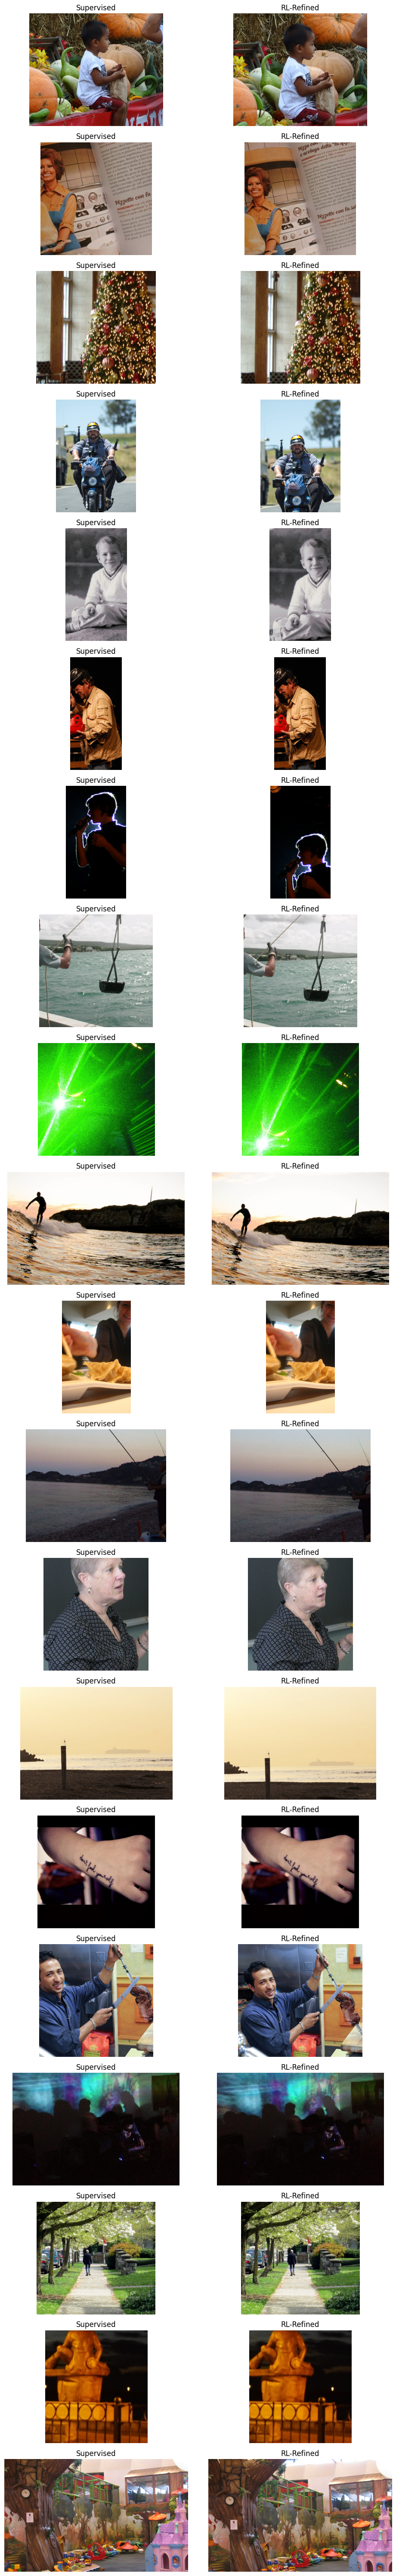

In [159]:


NUM_SAMPLES = 20

valid_indices = list(range(len(val_df)))
random.shuffle(valid_indices)

shown = 0
i = 0

plt.figure(figsize=(10, NUM_SAMPLES * 3))

while shown < NUM_SAMPLES and i < len(valid_indices):
    idx = valid_indices[i]
    i += 1

    sample = val_df.iloc[idx]
    img_path = sample["image_path"]

    # ---- load image safely ----
    image = cv2.imread(img_path)
    if image is None:
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Ground-truth box
    gt_box = np.array([
        sample["xc"],
        sample["yc"],
        sample["w"],
        sample["h"]
    ], dtype=np.float32)

    # Supervised prediction
    with torch.no_grad():
        img_tensor = transform(image).unsqueeze(0).to(device)
        pred_box = supervised_model(img_tensor).cpu().numpy()[0]

    init_box = clamp_box(pred_box)

    # Create RL environment
    env = CropEnv(
        image=image,
        gt_box=gt_box,
        init_box=init_box,
        max_steps=10
    )

    # Run ONE RL episode (inference only)
    with torch.no_grad():
        run_episode(env, policy)

    # Get crops
    supervised_crop = CropEnv(image, gt_box, init_box).get_crop()
    rl_crop = env.get_crop()

    # Plot
    plt.subplot(NUM_SAMPLES, 2, shown * 2 + 1)
    plt.imshow(supervised_crop)
    plt.title("Supervised")
    plt.axis("off")

    plt.subplot(NUM_SAMPLES, 2, shown * 2 + 2)
    plt.imshow(rl_crop)
    plt.title("RL-Refined")
    plt.axis("off")

    shown += 1

plt.tight_layout()
plt.show()


In [145]:
TEST_DIR = Path("../images/test")
test_images = list(TEST_DIR.glob("*.jpg")) + list(TEST_DIR.glob("*.png"))

print(f"Found {len(test_images)} test images")

Found 7 test images


In [146]:
def dummy_gt_box():
    # Centered, moderate size prior
    return np.array([0.5, 0.5, 0.6, 0.8])

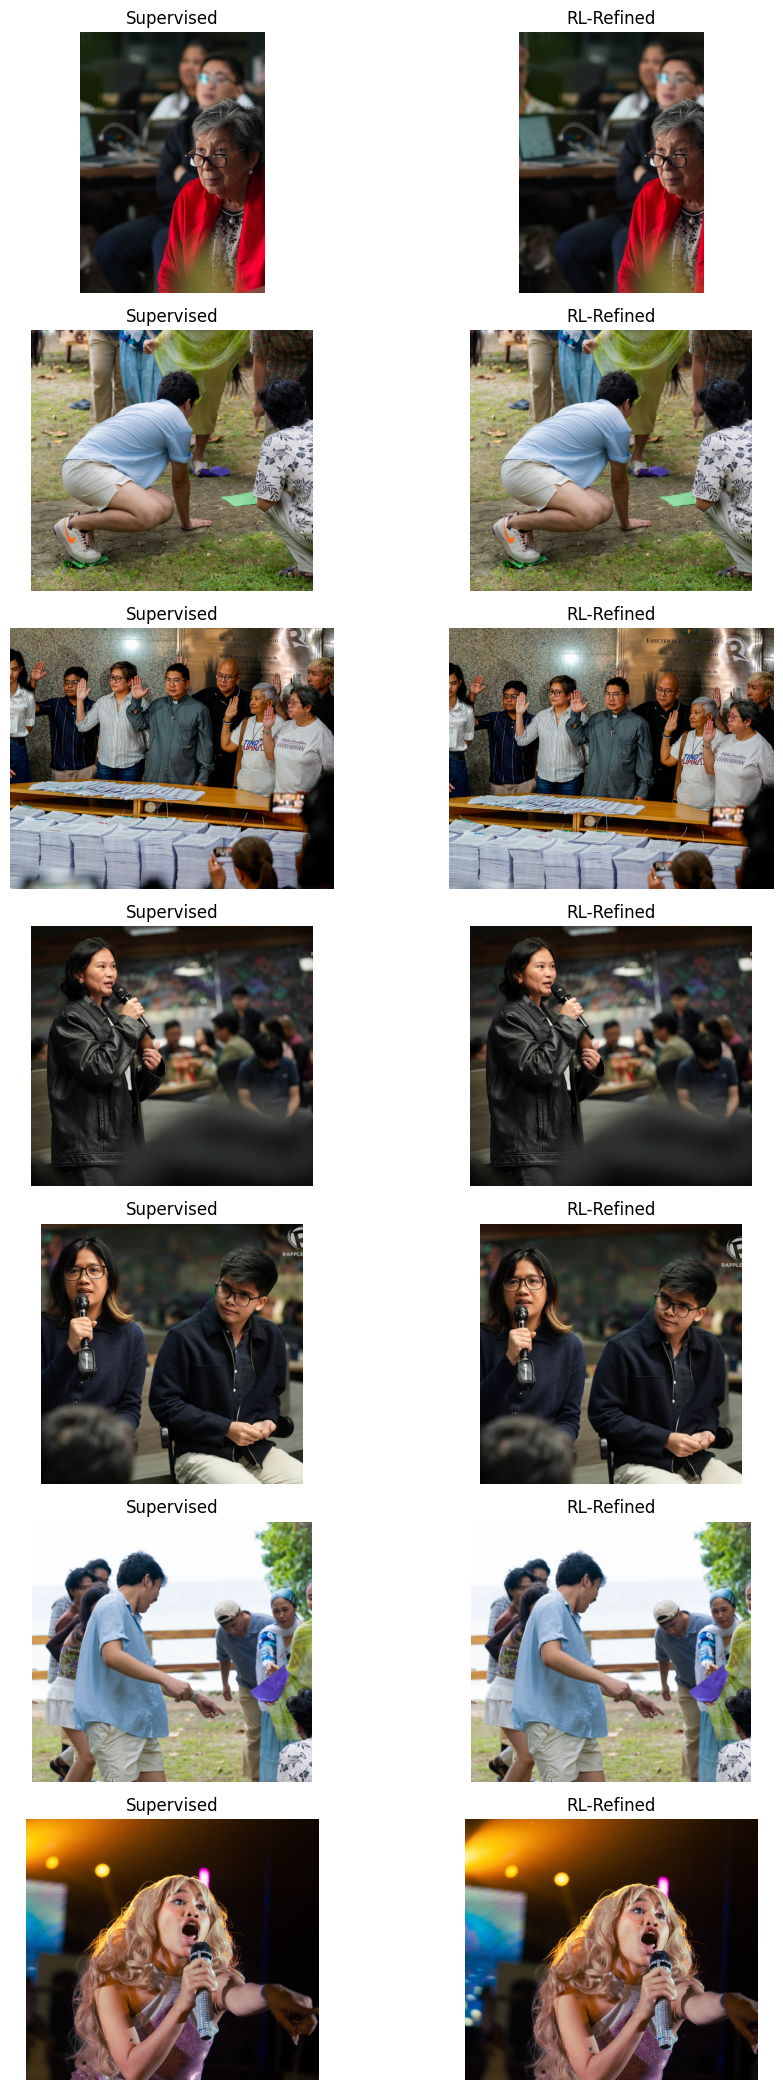

In [147]:
plt.figure(figsize=(10, len(test_images) * 3))

for i, img_path in enumerate(test_images):
    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Supervised crop
    with torch.no_grad():
        img_tensor = transform(image).unsqueeze(0).to(device)
        pred_box = supervised_model(img_tensor).cpu().numpy()[0]

    init_box = clamp_box(pred_box)

    # RL environment (no true GT)
    env = CropEnv(
        image=image,
        gt_box=dummy_gt_box(),   # weak prior
        init_box=init_box,
        max_steps=50             # keep it subtle
    )

    # Run RL refinement (no training)
    with torch.no_grad():
        run_episode(env, policy)

    supervised_crop = CropEnv(image, dummy_gt_box(), init_box).get_crop()
    rl_crop_test = env.get_crop()

    # Plot
    plt.subplot(len(test_images), 2, i*2 + 1)
    plt.imshow(supervised_crop)
    plt.title("Supervised")
    plt.axis("off")

    plt.subplot(len(test_images), 2, i*2 + 2)
    plt.imshow(rl_crop_test)
    plt.title("RL-Refined")
    plt.axis("off")

plt.tight_layout()
plt.show()
